# Batch Normalization

:label:`chapter_batch_norm`


Training deep models is difficult and getting them to converge in a reasonable
amount of time can be tricky.  In this section, we describe batch normalization (BN)
:cite:`Ioffe.Szegedy.2015`, one popular and effective technique that has been
found to accelerate the convergence of deep nets, and together with residual
blocks, which we cover in :numref:`chapter_resnet`, has recently enabled
practitioners to routinely train networks with over 100 layers.

## Training Deep Networks

Let's review some of the practical challenges when training deep networks.

1. Data preprocessing often proves to be a crucial consideration for effective
   statistical modeling. Recall our application of deep networks to
   predicting house prices in :numref:`chapter_kaggle_house`.
   In that example, we standardized our input features to each have a mean of
   *zero* and variance of *one*. Standardizing input data typically makes it
   easier to train models since parameters are a-priori at a similar scale.
1. For a typical MLP or CNN, as we train the model, the activations in
   intermediate layers of the network may assume different orders of magnitude
   (both across nodes in the same layer, and over time due to updating the
   model's parameters). The authors of the batch normalization technique
   postulated that this drift in the distribution of activations could hamper
   the convergence of the network. Intuitively, we might conjecture that if one
   layer has activation values that are 100x that of another layer, we might
   need to adjust learning rates adaptively per layer (or even per node within a
   layer).
1. Deeper networks are complex and easily capable of overfitting. This means
   that regularization becomes more critical. Empirically, we note that even
   with dropout, models can overfit badly and we might benefit from other
   regularization heuristics.

In 2015, a clever heuristic called batch normalization (BN) that has proved
immensely useful for improving the reliability and speed of convergence when
training deep models :cite:`Ioffe.Szegedy.2015`.  In each training iteration, BN
normalizes the activations of each hidden layer node (on each layer where it is
applied) by subtracting its mean and dividing by its standard deviation,
estimating both based on the current minibatch.  Note that if our batch size was
$1$, we wouldn't be able to learn anything because during training, every hidden
node would take value $0$.  However, with large enough minibatches, the approach
proves effective and stable.


In a nutshell, the idea in Batch Normalization is
to transform the activation at a given layer from $\mathbf{x}$ to

$$\mathrm{BN}(\mathbf{x}) = \mathbf{\gamma} \odot \frac{\mathbf{x} - \hat{\mathbf{\mu}}}{\hat\sigma} + \mathbf{\beta}$$

Here, $\hat{\mathbf{\mu}}$ is the estimate of the mean
and $\hat{\mathbf{\sigma}}$ is the estimate of the variance.
The result is that the activations are approximately rescaled
to zero mean and unit variance.
Since this may not be quite what we want,
we allow for a coordinate-wise scaling coefficient $\mathbf{\gamma}$
and an offset $\mathbf{\beta}$.
Consequently, the activations for intermediate layers
cannot diverge any longer: we are actively rescaling them back
to a given order of magnitude via $\mathbf{\mu}$ and $\sigma$.
Intuitively, it is hoped that this normalization allows us
to be more aggressive in picking large learning rates.
To address the fact that in some cases the activations
may actually *need* to differ from standardized data,
BN also introduces scaling coefficients $\mathbf{\gamma}$
and an offset $\mathbf{\beta}$.

In principle, we might want to use all of our training data
to estimate the mean and variance.
However, the activations correpsonding to each example
change each time we update our model.
To remedy this problem, BN uses only the current minibatch
for estimating $\hat{\mathbf{\mu}}$ and $\hat\sigma$.
It is precisely due to this fact
that we normalize based only on the *currect batch*
that *batch normalization* derives its name.
To indicate which minibatch $\mathcal{B}$ we draw this from,
we denote the quantities with $\hat{\mathbf{\mu}}_\mathcal{B}$
and $\hat\sigma_\mathcal{B}$.

$$\hat{\mathbf{\mu}}_\mathcal{B} \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ and }
\hat{\mathbf{\sigma}}_\mathcal{B}^2 \leftarrow \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \mathbf{\mu}_{\mathcal{B}})^2 + \epsilon$$

Note that we add a small constant $\epsilon > 0$ to the variance estimate
to ensure that we never end up dividing by zero,
even in cases where the empirical variance estimate might vanish by accident.
The estimates $\hat{\mathbf{\mu}}_\mathcal{B}$
and $\hat{\mathbf{\sigma}}_\mathcal{B}$ counteract the scaling issue
by using unbiased but noisy estimates of mean and variance.
Normally we would consider this a problem.
After all, each minibatch has different data,
different labels and with it, different activations, predictions and errors. As it turns out, this is actually beneficial.
This natural variation appears to act as a form of regularization,
conferring benefits (as observed empirically) in mitigating overfitting.
In other recent preliminary research, :cite:`Teye.Azizpour.Smith.2018` and :cite:`Luo.Wang.Shao.ea.2018` relate the properties of BN
to Bayesian Priors and penalties respectively.
In particular, this sheds some light on the puzzle why BN works best
for moderate sizes of minibatches in the range 50-100.

We are now ready to take a look at how batch normalization works in practice.


## Batch Normalization Layers

The batch normalization methods for fully-connected layers
and convolutional layers are slightly different.
This is due to the dimensionality of the data
generated by convolutional layers.
We discuss both cases below.
Note that one of the key differences between BN and other layers
is that BN operates on a a full minibatch at a time
(otherwise it cannot compute the mean and variance parameters per batch).

### Fully-Connected Layers

Usually we apply the batch normalization layer
between the affine transformation and the activation function
in a fully-connected layer.
In the following, we denote by $\mathbf{u}$ the input
and by $\mathbf{x} = \mathbf{W}\mathbf{u} + \mathbf{b}$ the output
of the linear transform.
This yields the following variant of BN:

$$\mathbf{y} = \phi(\mathrm{BN}(\mathbf{x})) =  \phi(\mathrm{BN}(\mathbf{W}\mathbf{u} + \mathbf{b}))$$

Recall that mean and variance are computed
on the *same* minibatch $\mathcal{B}$
on which the transformation is applied.
Also recall that the scaling coefficient $\mathbf{\gamma}$
and the offset $\mathbf{\beta}$ are parameters that need to be learned.
They ensure that the effect of batch normalization
can be neutralized as needed.

### Convolutional Layers

For convolutional layers, batch normalization occurs
after the convolution computation
and before the application of the activation function.
If the convolution computation outputs multiple channels,
we need to carry out batch normalization
for *each* of the outputs of these channels,
and each channel has an independent scale parameter and shift parameter,
both of which are scalars.
Assume that there are $m$ examples in the mini-batch.
On a single channel, we assume that the height and width
of the convolution computation output are $p$ and $q$, respectively.
We need to carry out batch normalization
for $m \times p \times q$ elements in this channel simultaneously.
While carrying out the standardization computation for these elements,
we use the same mean and variance.
In other words, we use the means and variances of the $m \times p \times q$ elements in this channel rather than one per pixel.


### Batch Normalization During Prediction

At prediction time, we might not have the luxury
of computing offsets per batch—we
might be required to make one prediction at a time.
Secondly, the uncertainty in $\mathbf{\mu}$ and $\mathbf{\sigma}$,
as arising from a minibatch are undesirable once we've trained the model.
One way to mitigate this is to compute more stable estimates
on a larger set for once (e.g. via a moving average)
and then fix them at prediction time.
Consequently, BN behaves differently during training and at test time
(recall that dropout also behaves differently at train and test times).

## Implementation from Scratch

Next, we will implement the batch normalization layer with ndarrays from scratch:

In [1]:
import d2l
from mxnet import autograd, gluon, np, npx, init
from mxnet.gluon import nn
npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use autograd to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is the prediction mode, directly use the mean and variance
        # obtained from the incoming moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcast operation
            # can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance of the moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

Now, we can customize a `BatchNorm` layer.
This retains the scale parameter `gamma`
and the shift parameter `beta`
involved in gradient finding and iteration,
and it also maintains the mean and variance
obtained from the moving average,
so that they can be used during model prediction.
The `num_features` parameter required by the `BatchNorm` instance
is the number of outputs for a fully-connected layer
and the number of output channels for a convolutional layer.
The `num_dims` parameter also required by this instance
is 2 for a fully-connected layer and 4 for a convolutional layer.

Besides the algorithm per se, also note
the design pattern in implementing layers.
Typically one defines the math in a separate function, say `batch_norm`.
This is then integrated into a custom layer
that mostly focuses on bookkeeping,
such as moving data to the right device context,
ensuring that variables are properly initialized,
keeping track of the running averages for mean and variance, etc.
That way we achieve a clean separation of math and boilerplate code.
Also note that for the sake of convenience
we did not add automagic size inference here,
hence we will need to specify the number of features throughout
(the Gluon version will take care of this for us).

In [2]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter involved in gradient
        # finding and iteration are initialized to 0 and 1 respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # All the variables not involved in gradient finding and iteration are
        # initialized to 0 on the CPU
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.zeros(shape)

    def forward(self, X):
        # If X is not on the CPU, copy moving_mean and moving_var to the
        # device where X is located
        if self.moving_mean.context != X.context:
            self.moving_mean = self.moving_mean.copyto(X.context)
            self.moving_var = self.moving_var.copyto(X.context)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## Use a Batch Normalization LeNet

Next, we will modify the LeNet model (:numref:`chapter_lenet`)
in order to apply the batch normalization layer.
We add the batch normalization layer
after all the convolutional layers and after all fully-connected layers.
As discussed, we add it  before the activation layer.

In [3]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

Next we train the modified model, again on Fashion-MNIST.
The code is virtually identical to that in previous steps.
The main difference is the considerably larger learning rate.

loss 0.249, train acc 0.909, test acc 0.814
23047.6 exampes/sec on gpu(0)


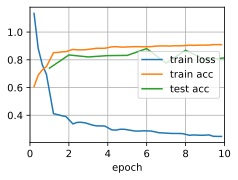

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

Let's have a look at the scale parameter `gamma`
and the shift parameter `beta` learned
from the first batch normalization layer.

In [5]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([2.2306864, 1.7035829, 2.1920984, 1.875589 , 1.69205  , 1.3903514], ctx=gpu(0)),
 array([ 1.3322672 ,  0.13703491,  0.01988783,  0.93734246, -1.7801632 ,
        -1.1116666 ], ctx=gpu(0)))

## Concise Implementation

Compared with the `BatchNorm` class, which we just defined ourselves,
the `BatchNorm` class defined by the `nn` model in Gluon is easier to use.
In Gluon, we do not have to define
the `num_features` and `num_dims` parameter values
required in the `BatchNorm` class.
Instead, these parameter values will be obtained automatically
by delayed initialization.
The code looks virtually identical
(save for the lack of an explicit specification
of the dimensionality of the features
for the Batch Normalization layers).

In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

Use the same hyper-parameter to carry out the training.
Note that as usual, the Gluon variant runs much faster
since its code has been compiled to C++/CUDA
vs our custom implementation,
which must be interpreted by Python.

loss 0.249, train acc 0.909, test acc 0.877
46317.0 exampes/sec on gpu(0)


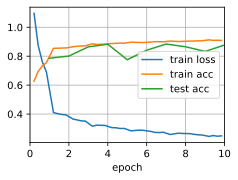

In [7]:
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

## Controversy

Intuitively, batch normalization is thought to somehow
make the optimization landscape smoother.
However, we must be careful to distinguish between
speculative intuitions and true explanations
for the phenomena that we observe when training deep models.
Recall that we do not even know why simpler
deep neural networks (MLPs and conventional CNNs) generalize so well.
Despite dropout and L2 regularization,
they remain too flexible to admit
conventional learning-theoretic generalization guarantees.

In the original paper proposing batch normalization,
the authors, in addition to introducing a powerful and useful tool
offered an explanation for why it works:
by reducing *internal covariate shift*.
Presumably by *internal covariate shift* the authors
meant something like the intuition expressed above---the
notion that the distribution of activations changes
over the course of training.
However there were two problems with this explanation:
(1) This drift is very different from *covariate shift*,
rendering the name a misnomer.
(2) The explanation remains ill-defined (and thus unproven)---rendering *why precisely this technique works* an open question.
Throughout this book we aim to convey the intuitions that practitioners
use to guide their development of deep neural networks.
However, it's important to separate these guiding heuristics
from established sceintific fact.
Eventually, when you master this material
and start writing your own research papers
you will want to be clear to delineate
between technical claims and hunches.

Following the success of batch normalization, its explanation and via *internal
covariate shift* became a hot topic that has been revisted several times both in
the technical literature and in the broader discourse about how machine learning
research ought to be presented.  Ali Rahimi popularly raised this issue during a
memorable speech while accepting a Test of Time Award at the NeurIPS conference
in 2017 and the issue was revisited in a recent position paper on troubling
trends in machine learning :cite:`Lipton.Steinhardt.2018`.  In the technical
literature other authors (:cite:`Santurkar.Tsipras.Ilyas.ea.2018`) have proposed
alternative explanations for the success of BN, some claiming that BN's success
comes despite exhibiting behavior that is in some ways opposite to those claimed
in the original paper.


## Summary

* During model training, batch normalization continuously adjusts the intermediate output of the neural network by utilizing the mean and standard deviation of the mini-batch, so that the values of the intermediate output in each layer throughout the neural network are more stable.
* The batch normalization methods for fully connected layers and convolutional layers are slightly different.
* Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.
* Batch Normalization has many beneficial side effects, primarily that of regularization. On the other hand, the original motivation of reducing covariate shift seems not to be a valid explanation.

## Exercises

1. Can we remove the fully connected affine transformation before the batch normalization or the bias parameter in convolution computation?
    * Find an equivalent transformation that applies prior to the fully connected layer.
    * Is this reformulation effective. Why (not)?
1. Compare the learning rates for LeNet with and without batch normalization.
    * Plot the decrease in training and test error.
    * What about the region of convergence? How large can you make the learning rate?
1. Do we need Batch Normalization in every layer? Experiment with it?
1. Can you replace Dropout by Batch Normalization? How does the behavior change?
1. Fix the coefficients `beta` and `gamma` (add the parameter `grad_req='null'` at the time of construction to avoid calculating the gradient), and observe and analyze the results.
1. Review the Gluon documentation for `BatchNorm` to see the other applications for Batch Normalization.
1. Research ideas - think of other normalization transforms that you can apply? Can you apply the probability integral transform? How about a full rank covariance estimate?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2358)

![](../img/qr_batch-norm.svg)